# General Overview

Dataset Resources: [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)

[Kaggle Link](https://www.kaggle.com/pavan2029/diabetic-data)

**Objective:**
Hospital readmission rates for certain conditions are now considered an indicator of hospital quality, and also affect the cost of care adversely. Hospital readmissions of diabetic patients are expensive as hospitals face penalties if their readmission rate is higher than expected and reflects the inadequacies in health care system. For these reasons, it is important for the hospitals to improve focus on reducing readmission rates. Identify the key factors that influence readmission for diabetes and to predict the probability of patient readmission. 

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.*

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

sns.set(style='darkgrid')
%matplotlib inline

### Import Dataset

In [ ]:
pd.read_csv('../input/diabetic-data/diabetic_data.csv').head()

In [ ]:
# csv contains "?" for missing values. We replace it with NaN
data = pd.read_csv('../input/diabetic-data/diabetic_data.csv', na_values=["?"])
df= data.copy()
df.head()

### Import Features Dataset
Descriptions of the features:
https://www.hindawi.com/journals/bmri/2014/781670/tab1/

In [ ]:
features = pd.read_csv('../input/diabetic-data-features-description/features.csv',index_col='Unnamed: 0')
info = lambda attribute:print(f"{attribute.upper()} : {features[features['Feature']==attribute]['Description'].values[0]}\n")
features.head()

In [ ]:
info('encounter_id')

### Check Duplicates

In [ ]:
df.duplicated().value_counts()
# df = df.drop_duplicates()

> no duplicates detected!

### Descriptive Analysis

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

display(summary(df).sort_values(by='Nulls', ascending=False))

* 'citoglipton' and 'examide' features that the number of uniques is 1 are droped.
* all values of 'encounter_id' column are unique. It has to be droped.

In [ ]:
df = df.drop(['citoglipton','examide','encounter_id'],axis=1)

### FOCUS ON "Gender"

In [ ]:
df.gender.value_counts(dropna=False)

> We regard the observations of "Unknown/Invalid" gender as null values and drop them.

In [ ]:
gender_index = df[df.gender == 'Unknown/Invalid'].index
df = df.drop(gender_index, axis=0)

In [ ]:
# confirm removal
df.gender.value_counts(dropna=False)

### FOCUS ON "readmitted"

In [ ]:
df.readmitted.value_counts(dropna=False)

> Patients readmitted to the hospital within and after 30 days will be combined into one column, because these patients ultimately returned.

In [ ]:
df = df.replace(['<30', '>30'], 'YES')

### FOCUS  ON " patient_nbr "

In [ ]:
info('patient_nbr')

In [ ]:
df['patient_nbr'].duplicated().value_counts(dropna=False)

* we can think of 'patient_nbr' as the id number of each patient.
* It turned out that the dataset is the data of 71515 unique patients.
* Some patients visited the hospital multiple times for treatment so to avoid over-representing any particular individual, only the first encounter with a patient will be used / kept in this dataset.

In [ ]:
# total unique patients
len(df.patient_nbr), df.patient_nbr.nunique()

In [ ]:
# locate number of patient visits using patient_id
df.patient_nbr.value_counts()

In [ ]:
# keep only one record for each patient, the first visit
df = df.drop_duplicates(['patient_nbr'], keep='first')
df.shape

In [ ]:
df.patient_nbr.nunique()

* Since patient_nbr is unique, it is no longer needed.

In [ ]:
df = df.drop('patient_nbr', axis=1)

### Dropping irrelevant columns

In [ ]:
 def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [ ]:
# columns with missing values
null_values(df)

In [ ]:
for i in ['weight','medical_specialty','payer_code']: info(i)

* The majority of patients do not have a weight listed so this column can be dropped. 
* Medical specialty and payer code are also missing for about half of the patients. 
* We do not need to know how the patients paid for their treatments.
* we do not have enough information to figure out which medical unit they went to.

In [ ]:
df = df.drop(['weight','medical_specialty','payer_code'], axis=1)

In [ ]:
summary(df).sort_values(by='Uniques', ascending=False)[:20]

In [ ]:
for i in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']: info(i)

* We dont need 'admission_type_id', 'discharge_disposition_id', 'admission_source_id' columns

In [ ]:
# drop columns
drop_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df = df.drop(drop_cols, axis=1)

### Handling Missing Values

In [ ]:
null_values(df)

In [ ]:
df.race.value_counts(dropna=False)

* Since there is no way to know the race of the patient using existing information, the best option is to remove those rows.

In [ ]:
df = df.dropna(axis=0, subset=['race'])
null_values(df)

In [ ]:
for i in ['diag_1', 'diag_2', 'diag_3']: info(i)

* You can reach the extensive diagnosis description on this website by querying with the ICD9 code:
http://icd9.chrisendres.com/

Now, we are down to three columns with missing information: diagnosis 1, 2, and 3. 
* Diagnosis 1 is described as the primary diagnosis made during the patient's visit while diagnosis 2 is the second and 3 is an any additional diagnoses made after that. 
* Looking at the patients' rows that are missing a primary diagnosis, most of them have a second diagnosis or even a third. 
* Since it doesn't make sense to have a second (or third) but not a primary diagnosis, we will remove these columns from the dataset.

In [ ]:
info('number_diagnoses')

In [ ]:
df[['diag_1', 'diag_2', 'diag_3','number_diagnoses']][df.diag_1.isnull() & df.diag_2.notnull() & df.diag_3.notnull() & df.number_diagnoses.notnull()]

The number of diagnoses column shows the total number of conditions a patient is diagnosed with. Only the first three are recorded, so those that are missing the first diagnosis but still a second or third are in error.

In [ ]:
# remove rows where diagnosis 1 is missing
df = df.dropna(axis=0, subset=['diag_1'])

There are two remaining diagnosis columns with missing values. Each number correlates to a specific condition so if there is a missing value, then it is likely that the patient only has one diagnosed condition. The number of diagnoses column lists the total number of diagnosed conditions. When looking at all three diagnosis columns, if the number is one, then diagnosis 2 and 3 can be filled in with a 0 to show that there is no additional diagnosis. If diagnosis 2 or 3 is missing a value and the number of diagnoses is greater than one, then some diagnoses were not recorded and the rows should be removed.

In [ ]:
null_values(df)

In [ ]:
df[['diag_1','diag_2', 'diag_3','number_diagnoses']][df.diag_2.isnull() & (df.diag_3.notnull()|(df.number_diagnoses > 1))]

In [ ]:
# remove rows where diagnosis 2 is missing and number of diagnoses is greater than 1
diag_2_indexes = df[df.diag_2.isnull() & (df.diag_3.notnull()|(df.number_diagnoses > 1))].index
df = df.drop(index = diag_2_indexes, axis=0)

In [ ]:
null_values(df)

Diagnosis 3 is the last column left with unaccounted missing values. Since some patients have 1 or 2 diagnosed conditions, the diagnosis 3 column is left intentionally blank. The goal here is to remove the rows that have a diagnoses number greater than two.

In [ ]:
# list of affected rows
df[['diag_1','diag_2', 'diag_3', 'number_diagnoses']][df.diag_3.isnull() & (df.number_diagnoses > 2)]

In [ ]:
# remove rows with missing diagnosis 3 and number of diagnoses is greater than 2
diag_3_indexes = df[(df.diag_3.isnull()) & (df.number_diagnoses > 2)].index
df = df.drop(index=diag_3_indexes, axis=0)

In [ ]:
null_values(df)

In [ ]:
sns.heatmap(df[['diag_1','diag_2', 'diag_3','number_diagnoses']].isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [ ]:
# replace NaN with None in diagnosis 2 and 3 to show there is no additional diagnosis
df.fillna('None', inplace=True)

In [ ]:
# confirm there are no more NaN values
null_values(df)

### Grouping Diagnosis Codes

In [ ]:
summary(df[['diag_1','diag_2', 'diag_3']])

* 'diag_1','diag_2' and 'diag_3' columns contain codes for the types of conditions patients are diagnosed with. 
* There are too much unique codes throughout this dataset.
* We can group the related icd9 diagnosis codes among themselves. In this way, we use categorical group names instead of numerical codes.
* The grouping is based on the research paper table (https://www.hindawi.com/journals/bmri/2014/781670/tab2/)
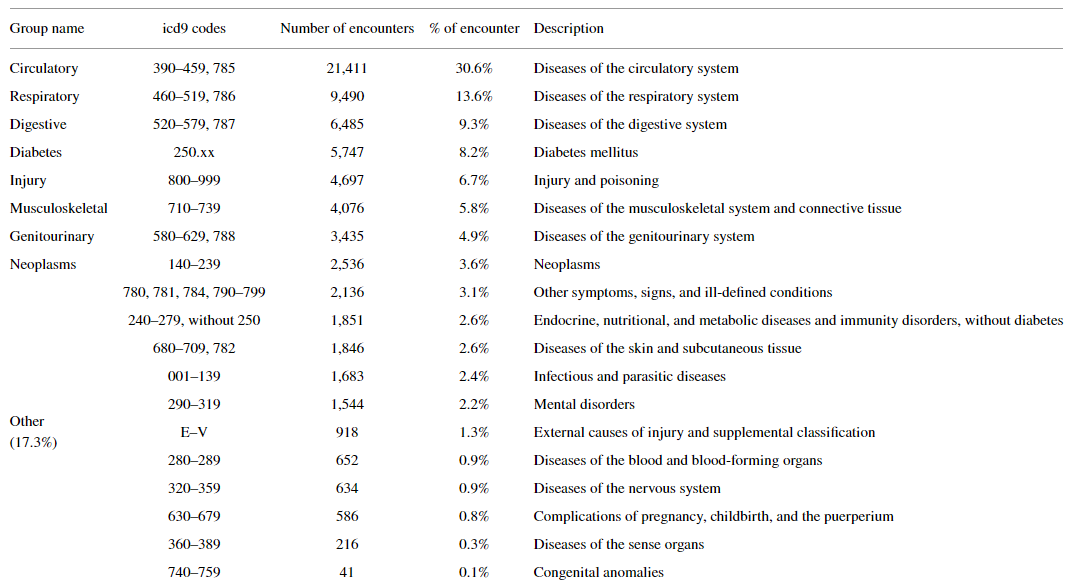

**Group Names**

    1-Circulatory
    2-Respiratory
    3-Digestive
    4-Diabetes
    5-Injury
    6-Musculoskeletal
    7-Genitourinary
    8-Neoplasms
    9-Other

In [ ]:
# Circulatory
codes =[str(i) for i in list(range(390,460)) + [785]]
df = df.replace(codes, 'Circulatory')

In [ ]:
# Respiratory
codes =[str(i) for i in list(range(460,520)) + [786]]
df = df.replace(codes, 'Respiratory')

In [ ]:
# Digestive
codes =[str(i) for i in list(range(520,580)) + [787]]
df = df.replace(codes, 'Digestive')

In [ ]:
# Diabetes
df = df.replace(regex=r'^250.*', value='Diabetes')

In [ ]:
# Injury
codes =[str(i) for i in range(800,1000)]
df = df.replace(codes, 'Injury')

In [ ]:
# Musculoskeletal
codes =[str(i) for i in range(710,740)]
df = df.replace(codes, 'Musculoskeletal')

In [ ]:
# Genitourinary
codes =[str(i) for i in list(range(580,630)) + [788]]
df = df.replace(codes, 'Genitourinary')

In [ ]:
# Neoplasms
codes =[str(i) for i in range(140,240)]
df = df.replace(codes, 'Neoplasms')

In [ ]:
# Other
df = df.replace(regex=r'^[E,V].*', value='Other')

codes =[str(i) for i in range(0,1000)]
df = df.replace(codes, 'Other')

In [ ]:
df[['diag_1', 'diag_2', 'diag_3']].head()

In [ ]:
# Unique Values of Each Features:
for i in df[['diag_1', 'diag_2', 'diag_3']]:
    print(f'{i}:\n{sorted(df[i].unique())}\n')

In [ ]:
# need to add 365.44 to Other
df = df.replace('365.44', 'Other') 

### Analysis of Diagnosis

In [ ]:
plt.figure(figsize=(20, 8))
for diag in ['diag_1','diag_2','diag_3']:
    sns.lineplot(x=df[diag].value_counts().sort_index().index, y= df[diag].value_counts().sort_index().values, marker='o')
plt.legend(['diag_1','diag_2','diag_3'])
plt.show()

* Looking at the graph above, we can say that there is a high correlation between the diagnoses. So we drop diag_2 and diag_3.
* Also since the most common diagnoses are prevalent in all three diagnoses listed, We are only using the primary diagnosis variable to build the machine learning model

In [ ]:
# drop diagnoses 2 and 3
df = df.drop(columns=['diag_2', 'diag_3'])

### FOCUS ON "`number_diagnoses`"

In [ ]:
plt.figure(figsize=(8,5))
ax = df.number_diagnoses.value_counts().sort_index().plot.bar()
def labels(ax, df=df):
    for p in ax.patches:
            ax.annotate('{:.0f}'.format(p.get_height()), 
                        (p.get_x(), p.get_height()+100),size=10)
labels(ax)

* For a small number of observations with number of diagnoses greater than 9, let's change the number of diagnoses to 9.

In [ ]:
df.number_diagnoses = df.number_diagnoses.replace([10,11,12,13,14,15,16],9)

### Outlier Detection

Based on the basic statistics describing the dataset, it looks there are outliers that influence skewness in the data. In order to represent the majority of samples and build clean models, we are going to remove outliers that have [z-scores](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/) greater than 3.0 or less than -3.0. This means that we are removing samples that are more (or less) than 3 times the standard deviation from the mean.

In [ ]:
df.describe().T

In [ ]:
features = df.describe().columns

In [ ]:
def col_plot(df,col_name):
    plt.figure(figsize=(15,6))
    
    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))
    
    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name]) # IQR katsayisi, defaultu 1.5
    plt.xlabel("IQR=1.5")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f), whis = 2.5)
    plt.xlabel("ROOT SQUARE - IQR=2.5")

    plt.subplot(144)
    plt.boxplot(np.log(df[col_name]+0.1), whis = 2.5)
    plt.xlabel("LOGARITMIC - IQR=2.5")
    plt.show()

In [ ]:
for i in features:
    col_plot(df,i)

In [ ]:
from scipy.stats.mstats import winsorize

def plot_winsorize(df,col_name,up=0.1,down=0):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    logr=np.log(df[col_name]+0.1)

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(logr, bins=22)
    plt.axvline(x=logr.mean()+3*logr.std(),color='red')
    plt.axvline(x=logr.mean()-3*logr.std(),color='red')
    plt.xlabel('Logr_col_name')

    plt.subplot(144)
    plt.boxplot(logr, whis = 1.5)
    plt.xlabel("Logaritmic - IQR=1.5")
    plt.show()    


In [ ]:
for i in features:
    plot_winsorize(df,i)

In [ ]:
df_winsorised=df.copy()
for i in features:
    df_winsorised[i]=winsorize(df_winsorised[i], (0,0.1))

In [ ]:
df_log=df.copy()
for i in features:
    df_log[i]=np.log(df_log[i])

In [ ]:
df_root=df.copy()
f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))
for i in features:
    df_root[i]=df_root[i].apply(f)

In [ ]:
from numpy import percentile
from scipy.stats import zscore
from scipy import stats

def outlier_zscore(df, col, min_z=1, max_z = 5, step = 0.1, print_list = False):
    z_scores = zscore(df[col].dropna())
    threshold_list = []
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append((threshold, len(np.where(z_scores > threshold)[0])))
        df_outlier = pd.DataFrame(threshold_list, columns = ['threshold', 'outlier_count'])
        df_outlier['pct'] = (df_outlier.outlier_count - df_outlier.outlier_count.shift(-1))/df_outlier.outlier_count*100
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0],2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) * df_outlier.iloc[df_outlier.pct.argmax(), 0])
    percentile_threshold = stats.percentileofscore(df[col].dropna(), outlier_limit)
    plt.vlines(best_treshold, 0, df_outlier.outlier_count.max(), 
               colors="r", ls = ":"
              )
    plt.annotate("Zscore : {}\nValue : {}\nPercentile : {}".format(best_treshold, outlier_limit, 
                                                                   (np.round(percentile_threshold, 3), 
                                                                    np.round(100-percentile_threshold, 3))), 
                 (best_treshold, df_outlier.outlier_count.max()/2))
    #plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, outlier_limit, percentile)

In [ ]:
from scipy.stats import zscore
from scipy import stats

def outlier_inspect(df, col, min_z=1, max_z = 5, step = 0.5, max_hist = None, bins = 50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1,3,1)
    if max_hist == None:
        sns.distplot(df[col], kde=False, bins = 50)
    else :
        sns.distplot(df[df[col]<=max_hist][col], kde=False, bins = 50)
   
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    z_score_inspect = outlier_zscore(df, col, min_z=min_z, max_z = max_z, step = step)
    
    plt.subplot(1,3,1)
    plt.axvline(x=df[col].mean() + z_score_inspect[2]*df[col].std(),color='red',linewidth=1,linestyle ="--")
    plt.axvline(x=df[col].mean() - z_score_inspect[2]*df[col].std(),color='red',linewidth=1,linestyle ="--")
    plt.show()
    
    return z_score_inspect

In [ ]:
def detect_outliers(df:pd.DataFrame, col_name:str, p=1.5) ->int:
    ''' 
    this function detects outliers based on 3 time IQR and
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(p*IQR)
    lower_limit = first_quartile-(p*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [ ]:
k=3
print(f"Number of Outliers for {k}*IQR\n")

total=0
for col in features:
    if detect_outliers(df, col)[2] > 0:
        outliers=detect_outliers(df, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

In [ ]:
k=3
print(f"Number of Outliers for {k}*IQR after Root Square\n")

total=0
for col in features:
    if detect_outliers(df_root, col)[2] > 0:
        outliers=detect_outliers(df_root, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

In [ ]:
k=3
print(f"Number of Outliers for {k}*IQR after Winsorised\n")

total=0
for col in features:
    if detect_outliers(df_winsorised, col)[2] > 0:
        outliers=detect_outliers(df_winsorised, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

In [ ]:
k=3
print(f"Number of Outliers for {k}*IQR after Logarithmed\n")

total=0
for col in features:
    if detect_outliers(df_log, col)[2] > 0:
        outliers=detect_outliers(df_log, col, k)[2]
        total+=outliers
        print("{} outliers in '{}'".format(outliers,col))
print("\n{} OUTLIERS TOTALLY".format(total))

In [ ]:
z_scores=[]
for i in features:
    z_scores.append(outlier_inspect(df,i)[2])

In [ ]:
z_scores

In [ ]:
features

In [ ]:
# Alternative 1
# df_3z=df.copy()
# for i in features:
#     down_limit= df_3z[i].mean() - (3*df_3z[i].std())
#     upper_limit= df_3z[i].mean() + (3*df_3z[i].std())
#     condition= (df_3z[i] > down_limit) & (df_3z[i] < upper_limit)
#     df_3z=df_3z[condition]

# print('Number of Outliers:',len(df)-len(df_3z))

In [ ]:
# Alternative 2

# create columns for z scores, new column with z score
df_3z=df.copy()

for x in features:
    df_3z[x + '_z'] = stats.zscore(df_3z[x])

for x in df_3z.columns[-len(features):]:
    df_3z = df_3z[(df_3z[x] < 3) & (df_3z[x] > -3)]
    
# drop _z columns
df_3z = df_3z.drop(columns=df_3z.columns[-8:])

print('Number of Outliers:',len(df)-len(df_3z))

In [ ]:
df_3z.describe().T.round(2)

In [ ]:
df.describe().T.round(2)

### Check Unique Values

Investigate the unique values of each column and look for error entries.

In [ ]:
summary(df_3z)

> Drop the columns that the number of uniques is 1

In [ ]:
df_3z = df_3z.drop(['acetohexamide','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1)

### Export Cleaned Dataset

In [ ]:
df_3z = df_3z.reset_index(drop=True)
df_3z.to_csv('./diabetic_data_cleaned.csv')